# 1. - Cкачиваем обученные модели и репозиторий

In [4]:
# Обычный дата сет
!gdown --id 1gHBxlneVeef3hZIY4IxeL-bpbLtjBXlC
!unzip -q -o *.zip -d /kaggle/working/extracted_data/

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1gHBxlneVeef3hZIY4IxeL-bpbLtjBXlC
From (redirected): https://drive.google.com/uc?id=1gHBxlneVeef3hZIY4IxeL-bpbLtjBXlC&confirm=t&uuid=6d58ef78-bc59-4a36-9b35-95866000fc88
To: /content/HW-2_env/rl-shortest-path-agent/base_grpo_model.zip
100%|█████████████████████████████████████████| 277M/277M [00:01<00:00, 237MB/s]


In [5]:
# Курикулум дата сет
!gdown --id 18eAgM-ZwMssGxHWdb8ehdWVII1uP2aif
!unzip -q -o curriculum_grpo_model.zip -d /kaggle/working/extracted_data/

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=18eAgM-ZwMssGxHWdb8ehdWVII1uP2aif
From (redirected): https://drive.google.com/uc?id=18eAgM-ZwMssGxHWdb8ehdWVII1uP2aif&confirm=t&uuid=78b7465c-6818-4b15-a555-2ff252ab05b1
To: /content/HW-2_env/rl-shortest-path-agent/curriculum_grpo_model.zip
100%|████████████████████████████████████████| 277M/277M [00:03<00:00, 89.8MB/s]


In [6]:
%cd /content
!rm -rf HW-2_env
!git clone https://github.com/TebelevGt/HW-2_env.git
%cd HW-2_env/rl-shortest-path-agent

/content
Cloning into 'HW-2_env'...
remote: Enumerating objects: 457, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 457 (delta 50), reused 89 (delta 41), pack-reused 354 (from 1)
Receiving objects: 100% (457/457), 6.85 MiB | 12.94 MiB/s, done.
Resolving deltas: 100% (216/216), done.
/content/HW-2_env/rl-shortest-path-agent


# 2. - Логика импортов

In [7]:
%%capture
import os
os.environ["UNSLOTH_VLLM_STANDBY"] = "1" # [NEW] Extra 30% context lengths!
if "COLAB_" not in "".join(os.environ.keys()):
    # If you're not in Colab, just use pip install or uv pip install
    !pip install unsloth vllm
else:
    pass # For Colab / Kaggle, we need extra instructions hidden below \/

In [8]:
#@title Colab Extra Install { display-mode: "form" }
#%%capture
import os
!pip install --upgrade -qqq uv
if "COLAB_" not in "".join(os.environ.keys()):
    # If you're not in Colab, just use pip install!
    !pip install unsloth vllm
else:
    try: import numpy, PIL; _numpy = f'numpy=={numpy.__version__}'; _pil = f'pillow=={PIL.__version__}'
    except: _numpy = "numpy"; _pil = "pillow"
    try: import subprocess; is_t4 = "Tesla T4" in str(subprocess.check_output(["nvidia-smi"]))
    except: is_t4 = False
    _vllm, _triton = ('vllm==0.9.2', 'triton==3.2.0') if is_t4 else ('vllm==0.15.1', 'triton')
    !uv pip install -qqq --upgrade {_vllm} {_numpy} {_pil} torchvision bitsandbytes xformers unsloth
    !uv pip install -qqq {_triton}
!uv pip install transformers==4.56.2
!uv pip install --no-deps trl==0.22.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 71.0 MB/s eta 0:00:00:00:0100:01
Using Python 3.12.12 environment at: /usr
Resolved 18 packages in 70ms                                         
Prepared 1 package in 494ms                                              
Uninstalled 1 package in 86ms
Installed 1 package in 64ms                                 
 - transformers==4.57.6
 + transformers==4.56.2
Using Python 3.12.12 environment at: /usr
Resolved 1 package in 1ms                                            
Prepared 1 package in 81ms                                               
Uninstalled 1 package in 2ms
Installed 1 package in 8ms                                  
 - trl==0.24.0
 + trl==0.22.2


In [9]:
import os
import torch
import gc
from unsloth import FastLanguageModel
from envs import evaluate_agent

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2026-02-23 08:26:11.453140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771835171.665226      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771835171.799377      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771835172.529521      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771835172.529561      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771835172.529564      55 computation_placer.cc:177] computation placer alr

INFO 02-23 08:26:51 [__init__.py:244] Automatically detected platform cuda.
ERROR 02-23 08:26:54 [fa_utils.py:57] Cannot use FA version 2 is not supported due to FA2 is only supported on devices with compute capability >= 8
🦥 Unsloth Zoo will now patch everything to make training faster!


# 3. - Валидация моделей

In [10]:
def evaluate_checkpoints(checkpoint_dirs, datasets, max_seq_length=8192):
    """
    Последовательно тестирует список чекпоинтов на списке датасетов.
    Если чекпоинт не найден, загружается базовая модель.
    """
    all_results = {}

    for ckpt in checkpoint_dirs:
        # Если пути нет, берем базовую модель
        model_name = ckpt if os.path.exists(ckpt) else "unsloth/Qwen2.5-1.5B-Instruct"
        print(f"\n🚀 Loading: {model_name} (Requested: {ckpt})")
        
        # Загрузка и подготовка модели
        model, tokenizer = FastLanguageModel.from_pretrained(
            model_name=model_name,
            max_seq_length=max_seq_length,
            load_in_4bit=True,
        )
        FastLanguageModel.for_inference(model)
        tokenizer.padding_side = "left" 
        
        all_results[ckpt] = {}
        
        # Прогон по датасетам
        for ds_path in datasets:
            print(f"🔎 Eval on: {ds_path}")
            res = evaluate_agent(
                model=model, 
                tokenizer=tokenizer, 
                dataset=ds_path, 
                device="cuda"
            )
            all_results[ckpt][ds_path] = res
            print(f"✅ Result: {res}")

        # Очистка ресурсов
        del model, tokenizer
        gc.collect()
        torch.cuda.empty_cache()
        
    return all_results

# Использование:
checkpoint_dirs = ["Just qwen","/kaggle/working/extracted_data/base_grpo_model","/kaggle/working/extracted_data/curriculum_grpo_model"]
datasets = ['data/test_easy.pkl', 'data/test_medium.pkl', 'data/test_hard.pkl']
results = evaluate_checkpoints(checkpoint_dirs, datasets)


🚀 Loading: unsloth/Qwen2.5-1.5B-Instruct (Requested: Just qwen)
==((====))==  Unsloth 2026.2.1: Fast Qwen2 patching. Transformers: 4.56.2. vLLM: 0.9.2.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.563 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.53G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

🔎 Eval on: data/test_easy.pkl


Evaluating (Batched): 100%|██████████| 25/25 [13:44<00:00, 32.99s/it]


✅ Result: {'accuracy': 0.09, 'format_compliance': 0.18500000000000005, 'hallucination_rate': 0.075, 'wrong_endpoint_rate': 0.02, 'optimal_rate': 0.06, 'avg_optimality_gap': 3.6666666666666665, 'avg_reasoning_len': 86.405}
🔎 Eval on: data/test_medium.pkl


Evaluating (Batched): 100%|██████████| 25/25 [16:52<00:00, 40.49s/it]


✅ Result: {'accuracy': 0.04, 'format_compliance': 0.08499999999999996, 'hallucination_rate': 0.035, 'wrong_endpoint_rate': 0.01, 'optimal_rate': 0.015, 'avg_optimality_gap': 5.875, 'avg_reasoning_len': 83.525}
🔎 Eval on: data/test_hard.pkl


Evaluating (Batched): 100%|██████████| 25/25 [25:20<00:00, 60.82s/it]


✅ Result: {'accuracy': 0.005, 'format_compliance': 0.04500000000000004, 'hallucination_rate': 0.04, 'wrong_endpoint_rate': 0.0, 'optimal_rate': 0.0, 'avg_optimality_gap': 15.0, 'avg_reasoning_len': 16.615}

🚀 Loading: /kaggle/working/extracted_data/base_grpo_model (Requested: /kaggle/working/extracted_data/base_grpo_model)
==((====))==  Unsloth 2026.2.1: Fast Qwen2 patching. Transformers: 4.56.2. vLLM: 0.9.2.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.563 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2026.2.1 patched 28 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


🔎 Eval on: data/test_easy.pkl


Evaluating (Batched): 100%|██████████| 25/25 [19:14<00:00, 46.17s/it]


✅ Result: {'accuracy': 0.01, 'format_compliance': 0.22999999999999998, 'hallucination_rate': 0.205, 'wrong_endpoint_rate': 0.015, 'optimal_rate': 0.0, 'avg_optimality_gap': 7.5, 'avg_reasoning_len': 255.55}
🔎 Eval on: data/test_medium.pkl


Evaluating (Batched): 100%|██████████| 25/25 [22:18<00:00, 53.54s/it]


✅ Result: {'accuracy': 0.015, 'format_compliance': 0.17000000000000004, 'hallucination_rate': 0.11, 'wrong_endpoint_rate': 0.045, 'optimal_rate': 0.005, 'avg_optimality_gap': 8.0, 'avg_reasoning_len': 108.7}
🔎 Eval on: data/test_hard.pkl


Evaluating (Batched): 100%|██████████| 25/25 [30:51<00:00, 74.06s/it]


✅ Result: {'accuracy': 0.005, 'format_compliance': 0.13, 'hallucination_rate': 0.1, 'wrong_endpoint_rate': 0.025, 'optimal_rate': 0.0, 'avg_optimality_gap': 9.0, 'avg_reasoning_len': 90.71}

🚀 Loading: /kaggle/working/extracted_data/curriculum_grpo_model (Requested: /kaggle/working/extracted_data/curriculum_grpo_model)
==((====))==  Unsloth 2026.2.1: Fast Qwen2 patching. Transformers: 4.56.2. vLLM: 0.9.2.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.563 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
🔎 Eval on: data/test_easy.pkl


Evaluating (Batched): 100%|██████████| 25/25 [19:06<00:00, 45.87s/it]


✅ Result: {'accuracy': 0.14, 'format_compliance': 0.28500000000000003, 'hallucination_rate': 0.06, 'wrong_endpoint_rate': 0.085, 'optimal_rate': 0.125, 'avg_optimality_gap': 0.8214285714285714, 'avg_reasoning_len': 122.86}
🔎 Eval on: data/test_medium.pkl


Evaluating (Batched): 100%|██████████| 25/25 [22:16<00:00, 53.47s/it]


✅ Result: {'accuracy': 0.07, 'format_compliance': 0.18000000000000005, 'hallucination_rate': 0.09, 'wrong_endpoint_rate': 0.02, 'optimal_rate': 0.05, 'avg_optimality_gap': 0.5714285714285714, 'avg_reasoning_len': 64.165}
🔎 Eval on: data/test_hard.pkl


Evaluating (Batched): 100%|██████████| 25/25 [30:46<00:00, 73.86s/it]


✅ Result: {'accuracy': 0.065, 'format_compliance': 0.14, 'hallucination_rate': 0.065, 'wrong_endpoint_rate': 0.01, 'optimal_rate': 0.01, 'avg_optimality_gap': 4.153846153846154, 'avg_reasoning_len': 52.575}


# 4. - Визуализация

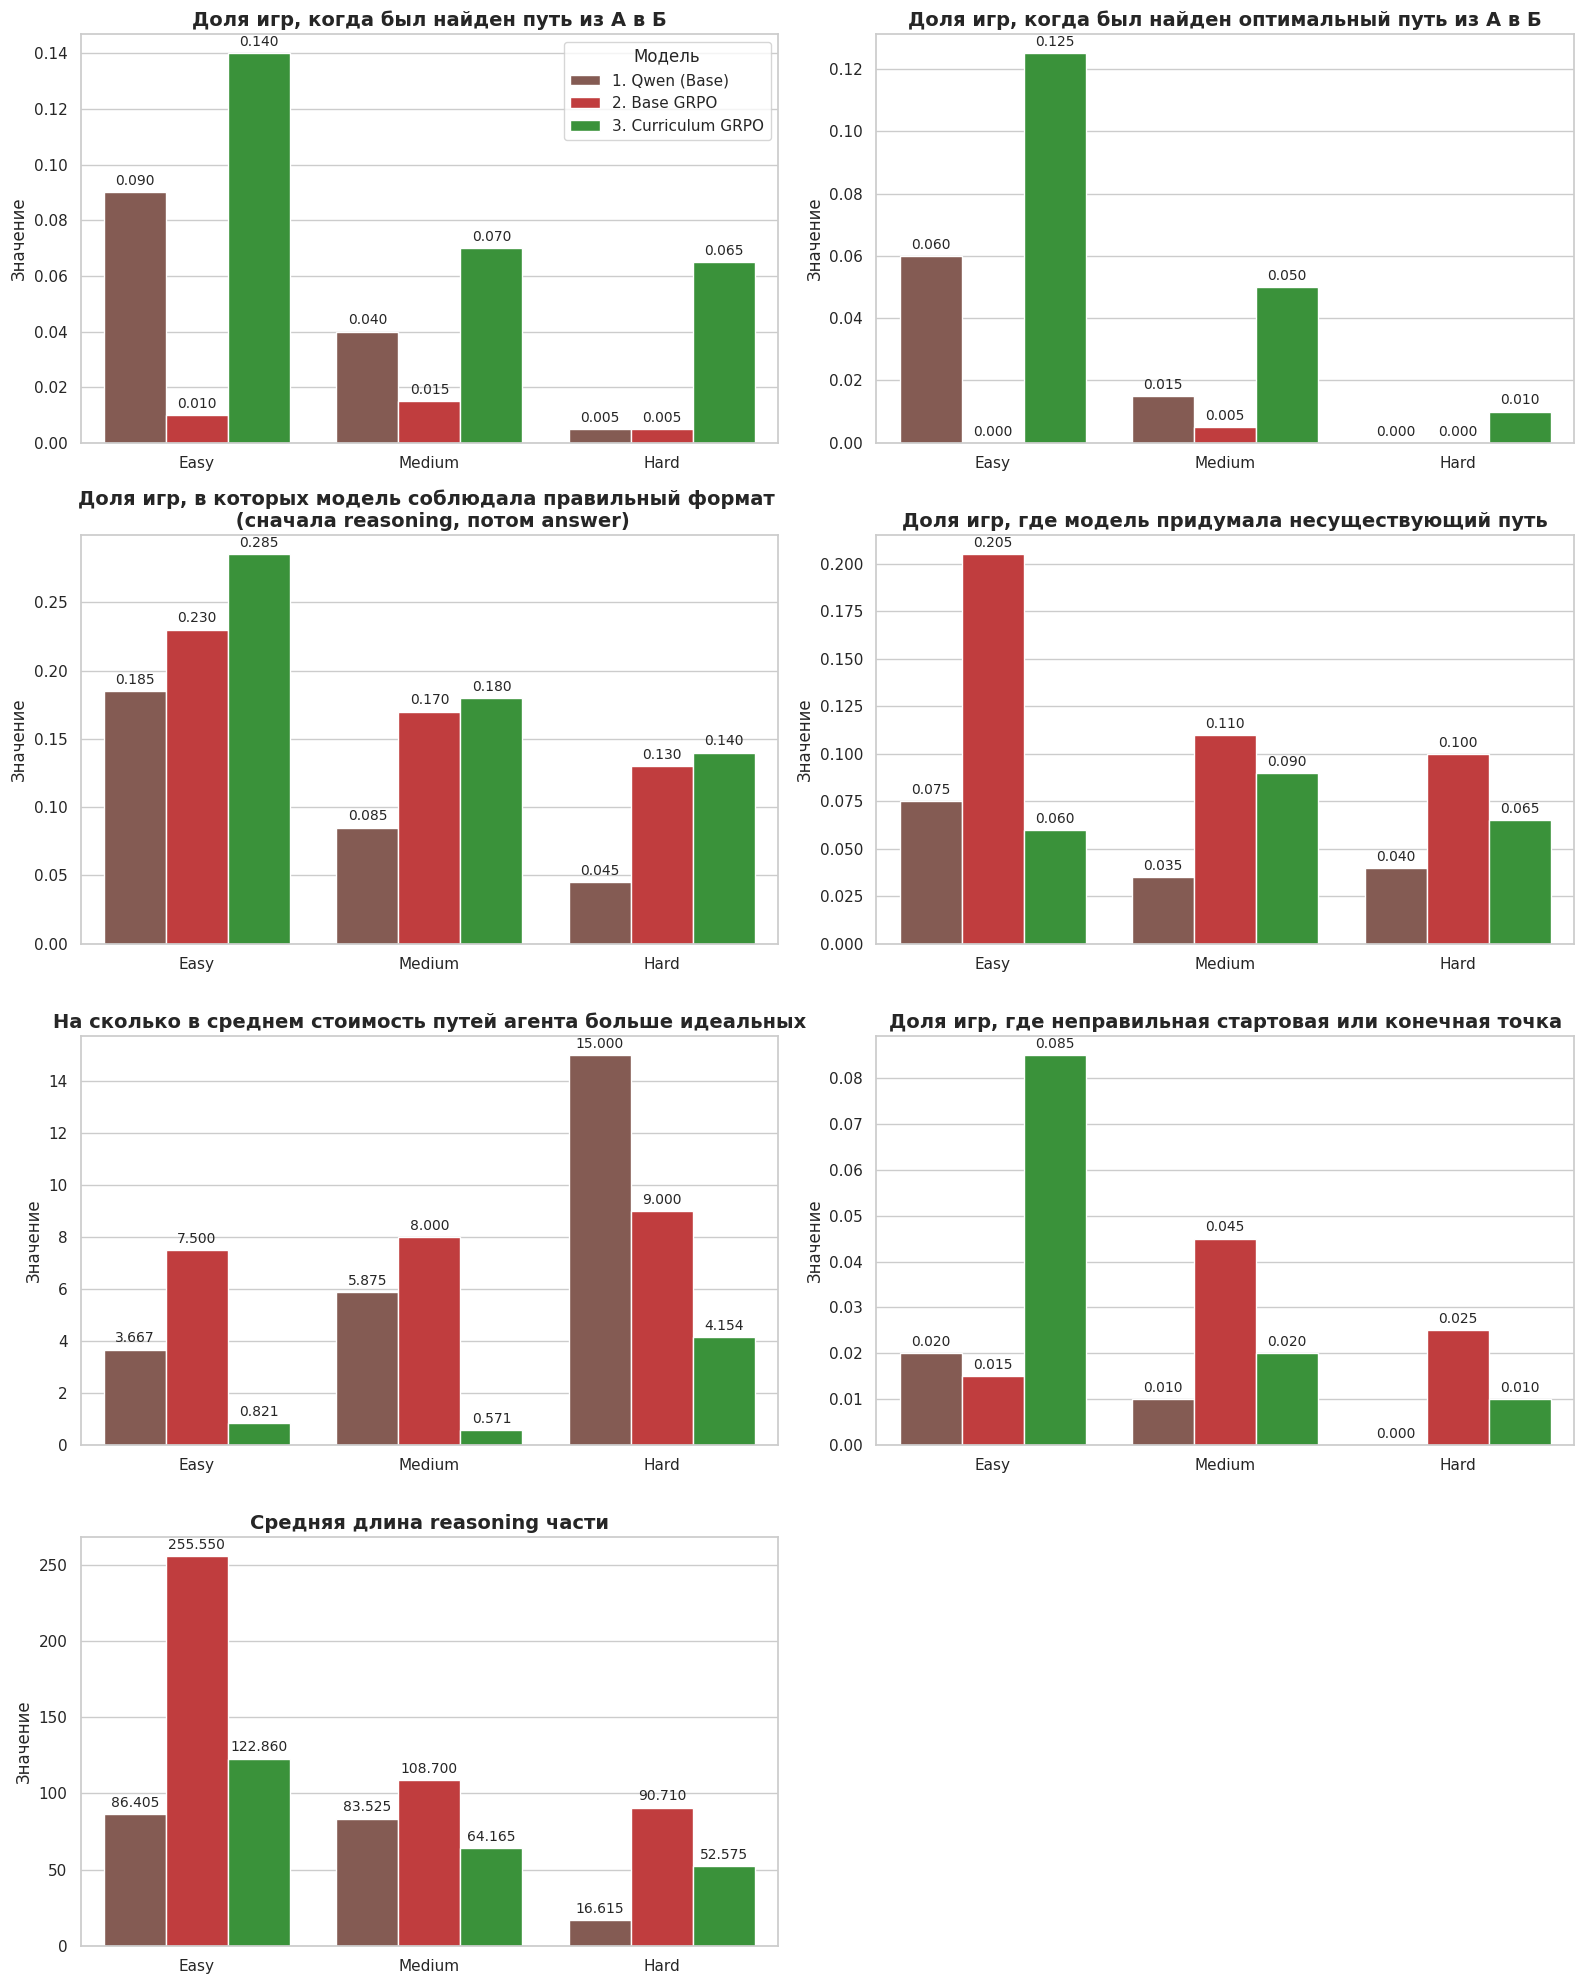

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# 2. Преобразуем словарь в плоский DataFrame для удобной отрисовки
rows = []
for model_raw, datasets in results.items():
    # Даем моделям читаемые имена
    if 'base_grpo' in model_raw: 
        model_name = '2. Base GRPO'
    elif 'curriculum' in model_raw: 
        model_name = '3. Curriculum GRPO'
    else: 
        model_name = '1. Qwen (Base)'
        
    for ds_raw, metrics in datasets.items():
        # Приводим названия датасетов к простому виду
        if 'easy' in ds_raw: ds = 'Easy'
        elif 'medium' in ds_raw: ds = 'Medium'
        else: ds = 'Hard'
            
        for metric, value in metrics.items():
            rows.append({'Model': model_name, 'Difficulty': ds, 'Metric': metric, 'Value': value})

df = pd.DataFrame(rows)

# Задаем правильный порядок уровней сложности
df['Difficulty'] = pd.Categorical(df['Difficulty'], categories=['Easy', 'Medium', 'Hard'], ordered=True)
df = df.sort_values(['Metric', 'Difficulty', 'Model'])

# 3. Словарь с понятными названиями для графиков
metric_titles = {
    'accuracy': 'Доля игр, когда был найден путь из А в Б',
    'optimal_rate': 'Доля игр, когда был найден оптимальный путь из А в Б',
    'format_compliance': 'Доля игр, в которых модель соблюдала правильный формат \n (сначала reasoning, потом answer)',
    'hallucination_rate': 'Доля игр, где модель придумала несуществующий путь',
    'avg_optimality_gap': 'На сколько в среднем стоимость путей агента больше идеальных',
    'wrong_endpoint_rate': 'Доля игр, где неправильная стартовая или конечная точка',
    'avg_reasoning_len': 'Средняя длина reasoning части'
}

# 4. Настройка и отрисовка
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(4, 2, figsize=(16, 20)) # Создаем сетку 4x2
axes = axes.flatten()

# Задаем цвета: База - Коричневый, Базовый GRPO - Красный (плохо), Curriculum - Зеленый (хорошо)
palette = {"1. Qwen (Base)": "#8c564b", "2. Base GRPO": "#d62728", "3. Curriculum GRPO": "#2ca02c"}

for i, metric in enumerate(metric_titles.keys()):
    ax = axes[i]
    sns.barplot(
        data=df[df['Metric'] == metric], 
        x='Difficulty', y='Value', hue='Model', 
        ax=ax, palette=palette
    )
    
    # Оформление графика
    ax.set_title(metric_titles[metric], fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Значение')
    
    # Добавляем подписи точных значений над столбцами
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3, fontsize=10)
        
    # Оставляем легенду только на первом графике, чтобы не захламлять остальные
    if i == 0:
        ax.legend(title='Модель', fontsize=11, title_fontsize=12, loc='upper right')
    else:
        if ax.get_legend() is not None:
            ax.legend_.remove()

# Удаляем 8-й пустой график (так как метрик всего 7)
fig.delaxes(axes[7])

plt.tight_layout()

# Сохраняем картинку и показываем ее
plt.savefig('/kaggle/working/metrics_visualization.png', dpi=150, bbox_inches='tight')
plt.show()